In [502]:
import pandas as pd 
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np

# tried to ignore warnings but they still appear
import warnings
warnings.filterwarnings('ignore', category=FutureWarning, module='sklearn')
warnings.filterwarnings('ignore', category=FutureWarning, module='pandas')
warnings.filterwarnings('ignore', category=FutureWarning, module='matplotlib')

data = pd.read_csv("Pharmaceuticals.csv")
numericalData = pd.DataFrame()

for column in data.columns:
    if data[column].dtype == "float64":
        numericalData[column] = data[column]
        
scaler = StandardScaler()
scaledData = scaler.fit_transform(numericalData)

kValues = [1, 3, 5, 7, 9]
euclideanVals = {}
labels = {}

wcssValues = []

for k in kValues: 
    # euclidean distance
    kmeans = KMeans(n_clusters=k, random_state=1)
    kmeans.fit(scaledData)        
    dist = kmeans.transform(scaledData)
    avgDist = np.mean(np.min(dist, axis=1))
    euclideanVals[k] = avgDist

    #elbow method
    wcssValues.append(kmeans.inertia_)

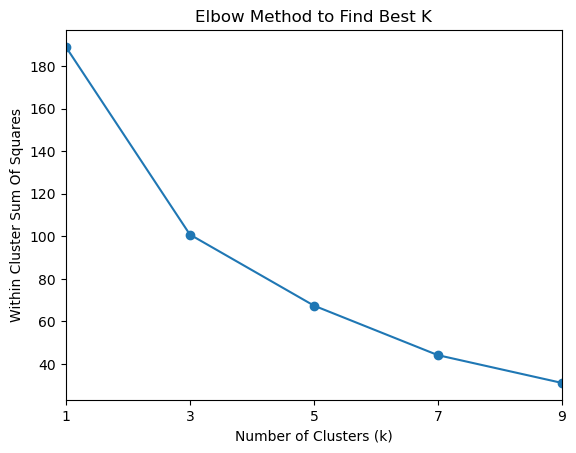

The elbow method is used as a visual to choose the best K. The optimal K would be the K closest to a 90 degree angle. 
This dataset does not give a clear visual as there is a substantial decrease in WCSS (Within Cluster Sum of Squares) as K increases.


In [503]:
# using elbow method to provide a visual analysis derived from https://www.geeksforgeeks.org/elbow-method-for-optimal-value-of-k-in-kmeans/
plt.plot(kValues, wcssValues, marker='o')
plt.xlim(1,9)
plt.title("Elbow Method to Find Best K")
plt.xlabel("Number of Clusters (k)")
plt.xticks(np.arange(1, 10, step=2))
plt.ylabel("Within Cluster Sum Of Squares")
plt.show()
print("The elbow method is used as a visual to choose the best K. The optimal K would be the K closest to a 90 degree angle. ")
print("This dataset does not give a clear visual as there is a substantial decrease in WCSS (Within Cluster Sum of Squares) as K increases.")

In [504]:
bestK = 0
bestDist = 1000
for k, distance in euclideanVals.items():
    if distance < bestDist:
        bestK = k
        bestDist = distance

print(f"Using Euclidean Distance, the best k is {bestK} with the distance of {bestDist}")
print("The best K was found with the method by finding the lowest distance between X and Y.")
print("X represents the transformed (or predicted) outcomes based on the model and the Y represents the actual outcome.")
print("Distance is calculated between X and Y.")

Using Euclidean Distance, the best k is 9 with the distance of 1.1354093870469018
The best K was found with the method by finding the lowest distance between X and Y.
X represents the transformed (or predicted) outcomes based on the model and the Y represents the actual outcome.
Distance is calculated between X and Y.


/var/folders/5w/8b3ms1m57cg2kh2m0j6dywyw0000gn/T/ipykernel_87314/3243539541.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data.groupby("Cluster").mean().plot()


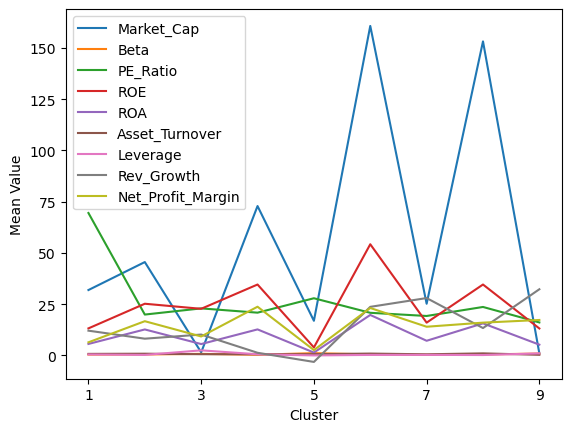

Based on the clusters above, there is a clear distinction between company market capitalization and leverage.  
The higher the market cap the lowert the leverage.
Market capitalization and return on equity are highly correlated.


In [505]:
# interpret clusters
kmeans = KMeans(n_clusters=bestK, random_state=1, n_init=10)
clusterLabels = kmeans.fit_predict(scaledData)

data["Cluster"] = clusterLabels
data["Cluster"] = data["Cluster"] + 1
data.groupby("Cluster").mean().plot()

plt.xlabel("Cluster")
plt.xticks(np.arange(1, 10, step=2))

plt.ylabel("Mean Value")

plt.show()
print("Based on the clusters above, there is a clear distinction between company market capitalization and leverage.  \nThe higher the market cap the lowert the leverage.")
print("Market capitalization and return on equity are highly correlated.")

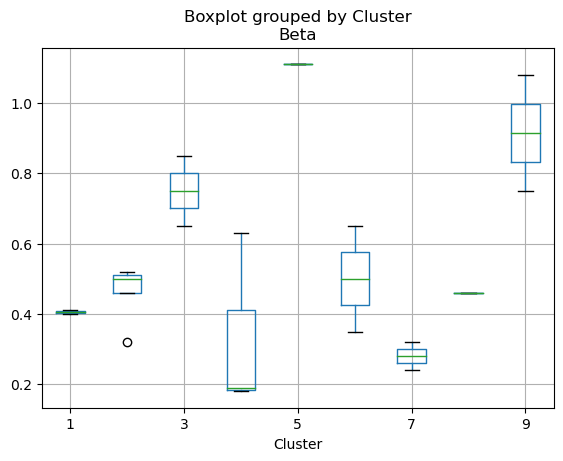

Based on the boxplot comparing the Beta of each Cluster, this dataset is too small for the number of clusters being used.


In [506]:
# box plot for each cluster
data.boxplot(column="Beta", by="Cluster")
plt.xlabel("Cluster")
plt.xticks(np.arange(1, 10, step=2))

plt.show()
print("Based on the boxplot comparing the Beta of each Cluster, this dataset is too small for the number of clusters being used.")

In [507]:
print(data.head())

  Symbol                 Name  Market_Cap  Beta  PE_Ratio   ROE   ROA  \
0    ABT  Abbott Laboratories       68.44  0.32      24.7  26.4  11.8   
1    AGN       Allergan, Inc.        7.58  0.41      82.5  12.9   5.5   
2    AHM         Amersham plc        6.30  0.46      20.7  14.9   7.8   
3    AZN      AstraZeneca PLC       67.63  0.52      21.5  27.4  15.4   
4    AVE              Aventis       47.16  0.32      20.1  21.8   7.5   

   Asset_Turnover  Leverage  Rev_Growth  Net_Profit_Margin  \
0             0.7      0.42        7.54               16.1   
1             0.9      0.60        9.16                5.5   
2             0.9      0.27        7.05               11.2   
3             0.9      0.00       15.00               18.0   
4             0.6      0.34       26.81               12.9   

  Median_Recommendation Location Exchange  Cluster  
0          Moderate Buy       US     NYSE        2  
1          Moderate Buy   CANADA     NYSE        1  
2            Strong Buy      

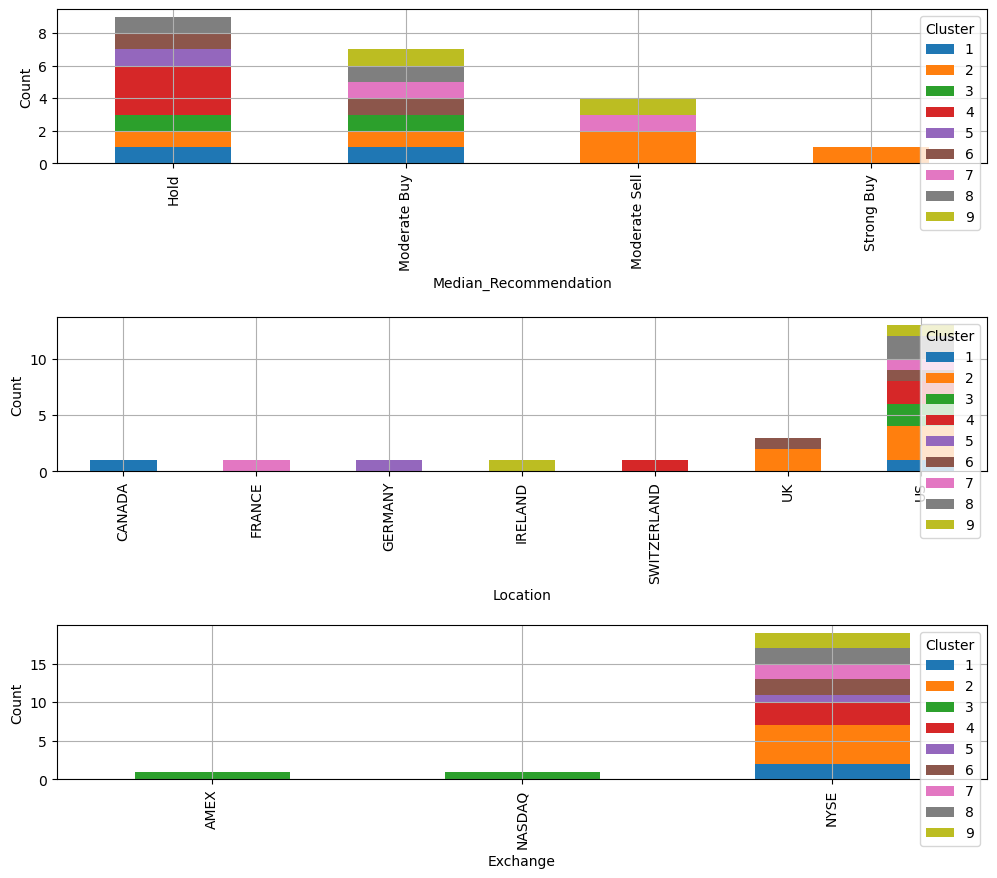

In [508]:
# compare clusters against categorical labels not used in the clustering formation
catLabels = ["Median_Recommendation", "Location", "Exchange"]
fig, axes = plt.subplots(len(catLabels), 1, figsize=(12, 10))
plt.subplots_adjust(hspace=1)

for i, lab in enumerate(catLabels):
    ax = axes[i]
    gpd = data.groupby([lab, "Cluster"]).size().unstack()
    # print(gpd)
    gpd.plot(kind='bar', stacked=True, ax=ax)

    ax.set_xlabel(lab)
    ax.set_ylabel('Count')
    ax.legend(title='Cluster', loc='upper right')
    ax.grid(True)
    

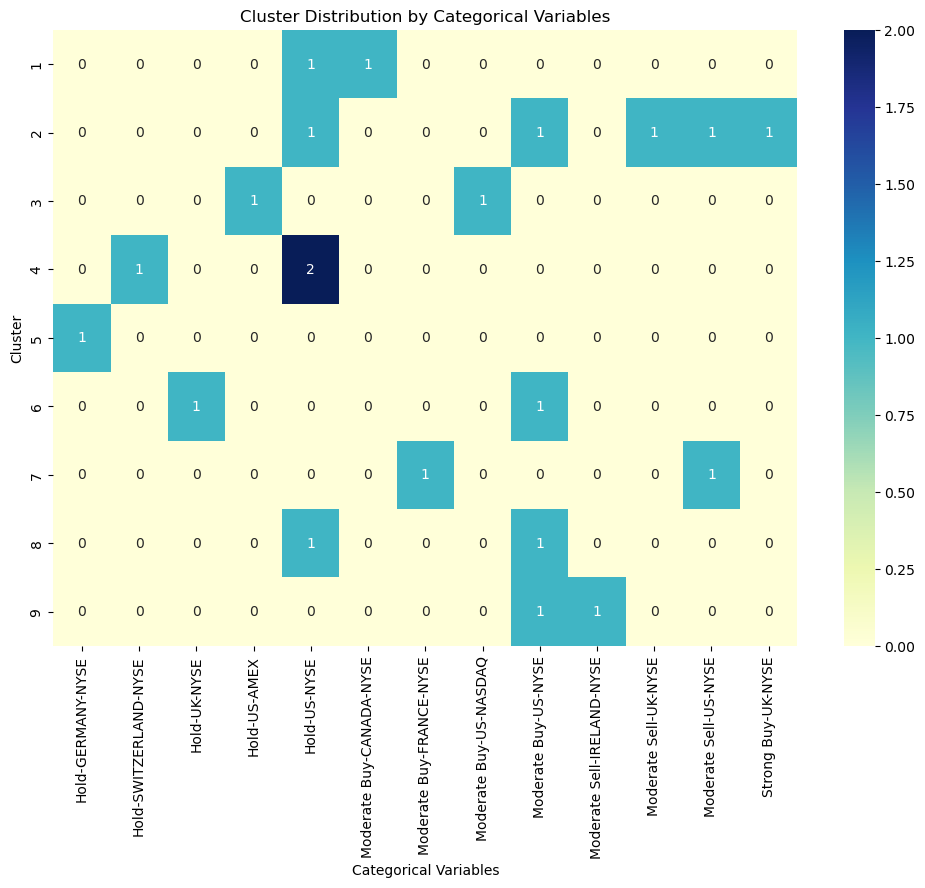

The dataset is too broad to use 9 clusters.  Naming them would not be beneficial and it would be too specific.
Below I will be using k = 3 for the elbow method to see if this helps narrow down the clusters to assign a naming convention.


In [509]:
import seaborn as sns
pivotData = data.pivot_table(index="Cluster", columns=catLabels, aggfunc='size', fill_value=0)

plt.figure(figsize=(12, 8))
sns.heatmap(pivotData, annot=True, fmt='d', cmap='YlGnBu', cbar=True)

plt.xlabel('Categorical Variables')
plt.ylabel('Cluster')
plt.title('Cluster Distribution by Categorical Variables')
plt.show()
print("The dataset is too broad to use 9 clusters.  Naming them would not be beneficial and it would be too specific.")
print("Below I will be using k = 3 for the elbow method to see if this helps narrow down the clusters to assign a naming convention.")

/var/folders/5w/8b3ms1m57cg2kh2m0j6dywyw0000gn/T/ipykernel_87314/959035002.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data.groupby("Cluster").mean().plot()


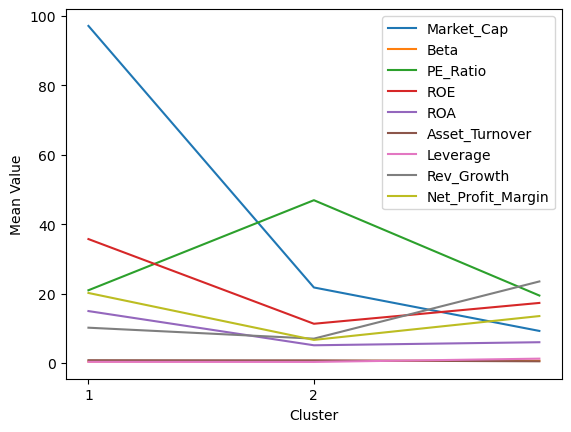

In [510]:
# redo analysis using k = 3
bestK = 3
kmeans = KMeans(n_clusters=bestK, random_state=1, n_init=10)
clusterLabels = kmeans.fit_predict(scaledData)

data["Cluster"] = clusterLabels 
data["Cluster"] = data["Cluster"] + 1
data.groupby("Cluster").mean().plot()

plt.xlabel("Cluster")
plt.xticks(np.arange(1, 3, step=1))
plt.ylabel("Mean Value")

plt.show()

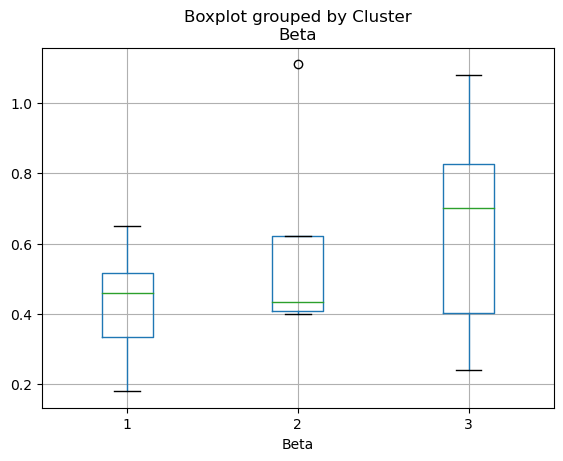

In [511]:
# box plot for each cluster
data.boxplot(column="Beta", by="Cluster")
plt.xlabel("Beta")
plt.xticks(np.arange(1, 4, step=1))
plt.show()

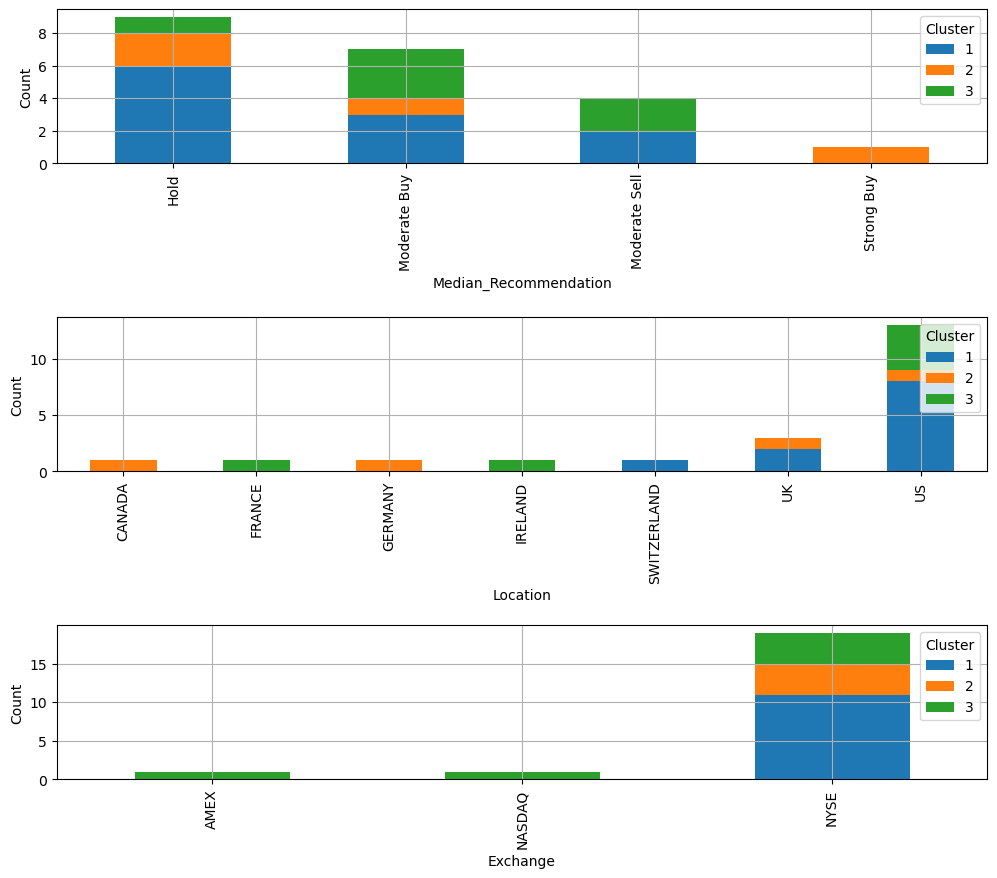

In [512]:
# 
catLabels = ["Median_Recommendation", "Location", "Exchange"]
fig, axes = plt.subplots(len(catLabels), 1, figsize=(12, 10))
plt.subplots_adjust(hspace=1)

for i, lab in enumerate(catLabels):
    ax = axes[i]
    gpd = data.groupby([lab, "Cluster"]).size().unstack()
    # print(gpd)
    gpd.plot(kind='bar', stacked=True, ax=ax)

    ax.set_xlabel(lab)
    ax.set_ylabel('Count')
    ax.legend(title='Cluster', loc='upper right')
    ax.grid(True)

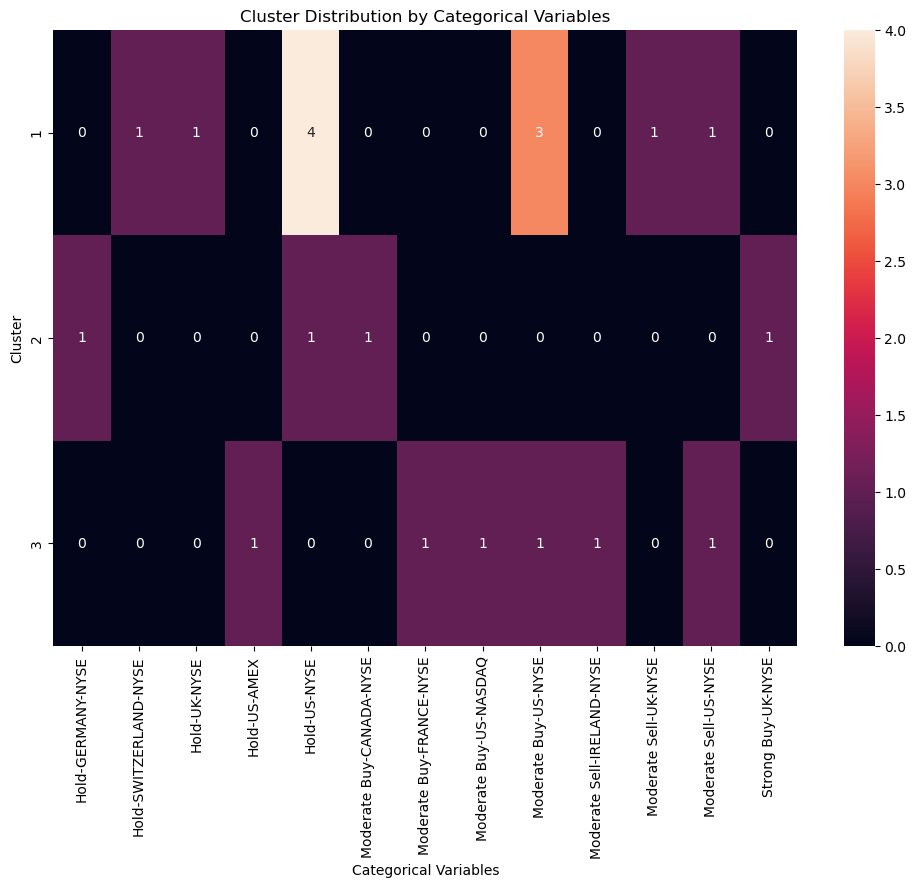

In [513]:
# heatmap
pivotData = data.pivot_table(index="Cluster", columns=catLabels, aggfunc='size', fill_value=0)

plt.figure(figsize=(12, 8))
sns.heatmap(pivotData, annot=True, cbar=True)

plt.xlabel('Categorical Variables')
plt.title('Cluster Distribution by Categorical Variables')
plt.show()

In [514]:
print("After analyzing using k=3, I do not think any of the clusters can be named using the categorical labels (10-12).")
print("KMeans does not fit the dataset very well.")

After analyzing using k=3, I do not think any of the clusters can be named using the categorical labels (10-12).
KMeans does not fit the dataset very well.


In [515]:
# Cross Validation of k=3 using KFold and silhouette scoring https://towardsdatascience.com/silhouette-coefficient-validating-clustering-techniques-e976bb81d10c
kf = KFold(n_splits=5, shuffle=True, random_state=1)

silScores = []
for train, test in kf.split(scaledData):
    xTrain, xTest = scaledData[train], scaledData[test]
    
    kmeans = KMeans(n_clusters=3, random_state=1)
    kmeans.fit(xTrain)
    
    testClusters = kmeans.predict(xTest)
                
    silAvg = silhouette_score(xTest, testClusters)
    silScores.append(silAvg)

avgSilScores = np.mean(silScores)
print("Silhouette score: ", avgSilScores)
print("Based on this silhouette score, the clusters are not distributed well for the dataset.  Scoring ranges from -1 to 1.")


Silhouette score:  0.12325469961902154
Based on this silhouette score, the clusters are not distributed well for the dataset.  Scoring ranges from -1 to 1.
